## Ireland Covid-19 datasets

* https://data.gov.ie/dataset?q=covid&sort=score+desc%2C+metadata_created+desc
* https://www.hpsc.ie/a-z/respiratory/coronavirus/novelcoronavirus/casesinireland/epidemiologyofcovid-19inireland/
* https://covid19ireland-geohive.hub.arcgis.com/

In [189]:
import pandas as pd
import pylab as plt
import numpy as np
import seaborn as sns
import matplotlib as mpl
import pylab as plt
import matplotlib.dates as mdates
sns.set_context('talk')
locator = mdates.AutoDateLocator(minticks=4, maxticks=8)
formatter = mdates.ConciseDateFormatter(locator)

In [214]:
labs = pd.read_csv('http://opendata-geohive.hub.arcgis.com/datasets/f6d6332820ca466999dbd852f6ad4d5a_0.csv?outSR={%22latestWkid%22:3857,%22wkid%22:102100}')
labs['date'] = pd.to_datetime(labs['Date_HPSC'], infer_datetime_format=True)
labs

,Date_HPSC,Hospitals,TotalLabs,NonHospitals,Positive,PRate,Test24,Test7,Pos7,PosR7,FID,date
0,2020/03/18 11:00:00+00,9,6457,6448,395,6.1,0,0,0,0.0,1,2020-03-18 11:00:00
1,2020/03/19 11:00:00+00,40,7403,7363,465,6.3,946,0,0,0.0,2,2020-03-19 11:00:00
2,2020/03/20 11:00:00+00,599,8872,8273,570,6.4,1469,0,0,0.0,3,2020-03-20 11:00:00
3,2020/03/21 11:00:00+00,1261,10436,9175,625,6.0,1564,0,0,0.0,4,2020-03-21 11:00:00
4,2020/03/22 11:00:00+00,1370,11414,10044,744,6.5,978,0,0,0.0,5,2020-03-22 11:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...
149,2020/08/14 11:00:00+00,270359,699036,428677,30270,4.3,11337,41139,586,1.4,150,2020-08-14 11:00:00
150,2020/08/15 11:00:00+00,272543,709689,437146,30392,4.3,10653,46912,571,1.2,151,2020-08-15 11:00:00
151,2020/08/16 11:00:00+00,274307,720041,445734,30481,4.2,10352,53157,605,1.1,152,2020-08-16 11:00:00
152,2020/08/17 11:00:00+00,276113,725574,449461,30651,4.2,5533,54816,715,1.3,153,2020-08-17 11:00:00


In [215]:
labs['Positive_diff'] = labs.Positive.diff()
labs['Tests_diff'] = labs.TotalLabs.diff()

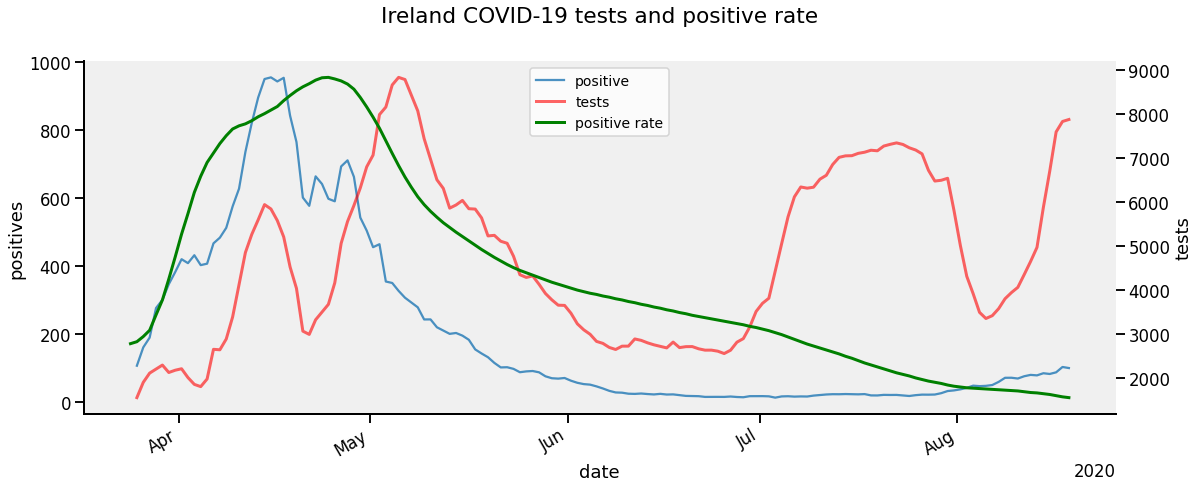

In [217]:
window=7
x=labs.set_index('date').rolling(window).mean()
f,ax=plt.subplots(figsize=(17,7))
l1=x.plot(y='Positive_diff',ax=ax,legend=False,alpha=.8)
ax1=ax.twinx()
x.plot(y='Tests_diff',ax=ax1,color='red',lw=3,legend=False,alpha=.6)
ax.set_ylabel('positives')
ax.set_facecolor('#f0f0f0')

ax2=ax.twinx()
ax2.axis('off')
x.plot(y='PRate',ax=ax2,color='green',lw=3,legend=False)
ax.legend([ax.get_lines()[0],ax1.get_lines()[0],ax2.get_lines()[0]],['positive','tests','positive rate'],loc=9,fontsize=14)
ax1.set_ylabel('tests')
f.suptitle('Ireland COVID-19 tests and positive rate')

ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
sns.despine()
plt.tight_layout()
f.savefig('ireland_covid_tests_prate.png',dpi=150)

In [184]:
cs = pd.read_csv('http://opendata-geohive.hub.arcgis.com/datasets/d9be85b30d7748b5b7c09450b8aede63_0.csv?outSR={%22latestWkid%22:3857,%22wkid%22:102100}')
cs['time'] = pd.to_datetime(cs['TimeStamp'], infer_datetime_format=True)
cs = cs.sort_values(['CountyName','time'])
cs.columns

Index(['OBJECTID', 'ORIGID', 'CountyName', 'PopulationCensus16', 'TimeStamp',
       'IGEasting', 'IGNorthing', 'Lat', 'Long', 'UGI', 'ConfirmedCovidCases',
       'PopulationProportionCovidCases', 'ConfirmedCovidDeaths',
       'ConfirmedCovidRecovered', 'Shape__Area', 'Shape__Length', 'time'],
      dtype='object')

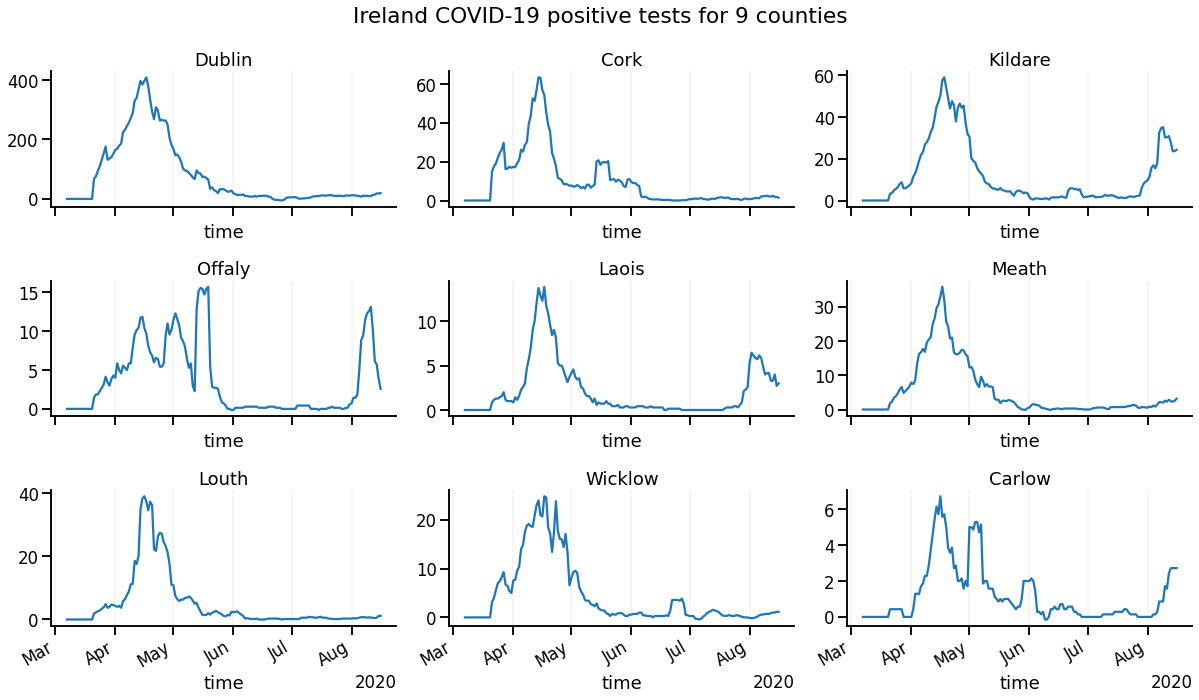

In [212]:
x=cs.set_index('time')#.rolling(window).mean()
f,ax=plt.subplots(3,3,figsize=(17,10))
axs=ax.flat
grouped = cs.groupby('CountyName')
i=0
for c in ['Dublin','Cork','Kildare','Offaly','Laois','Meath','Louth','Wicklow','Carlow']:
    ax=axs[i]
    x = cs[cs.CountyName==c].set_index('time').rolling(window).mean()
    x['cases'] = x['ConfirmedCovidCases'].diff() 
    x.plot(y='cases',ax=ax,legend=False)
    ax.set_title(c)
    ax.xaxis.set_major_locator(locator)
    ax.grid(axis='x',color='0.95')
    if i>5:
        ax.xaxis.set_major_formatter(formatter)
    else:
        ax.set_xticklabels([])
    i+=1
sns.despine()
f.suptitle('Ireland COVID-19 positive tests for 9 counties')
plt.tight_layout()
f.savefig('ireland_covid_tests_bycounty.png',dpi=150)
